In [254]:
using POMDPs

In [255]:
using POMDPModelTools

In [256]:
using POMDPPolicies

In [257]:
using QuickPOMDPs

In [258]:
using Parameters, Random

In [259]:
using Plots; default(fontfamily="Computer Modern", framestyle=:box) # LaTex-style

In [260]:
using ColorSchemes, Colors

In [261]:
cmap = ColorScheme([Colors.RGB(180/255, 0.0, 0.0), Colors.RGB(1, 1, 1), Colors.RGB(0.0, 100/255, 0.0)], "custom", "threetone, red, white, and green")

In [262]:
ColorScheme([get(cmap, i) for i in 0.0:0.001:1.0])

In [486]:
# plot the U values (maximum Q over the actions)
# x = row, y = column, z = U-value
function plot_grid_world(mdp::MDP,
    policy::Policy=NothingPolicy(),
    iter=0,
    discount=NaN;
    outline=true,
    show_policy=true,
    extra_title=isnan(discount) ? "" : " (iter=$iter, γ=$discount)",
    show_rewards=false,
    outline_state::Union{State, Nothing}=nothing)

gr()

if policy isa NothingPolicy
    # override when the policy is empty
    show_policy = false
end

if iter == 0
    # solver has not been run yet, so we just plot the raw rewards
    # overwrite policy at time=0 to be emp
    U = get_rewards(mdp, policy)
else
    # otherwise, use the Value Function to get the values (i.e., utility)
    U = values(mdp, policy)
end

# reshape to grid
(xmax, ymax) = params.size
Uxy = reshape(U, xmax, ymax)


# plot values (i.e the U matrix)
fig = Plots.heatmap(Uxy',
              legend=:none,
              aspect_ratio=:equal,
              framestyle=:box,
              tickdirection=:out,
              color=cmap.colors)
xlims!(0.5, xmax+0.5)
ylims!(0.5, ymax+0.5)
xticks!(1:xmax)
yticks!(1:ymax)

rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

if show_rewards
    for s in filter(s->reward(mdp, s) != 0, states(mdp))
        r = reward(mdp, s)
        annotate!([(s.x, s.y, (r, :white, :center, 12, "Computer Modern"))])
    end
end

for x in 1:xmax, y in 1:ymax
    # display policy on the plot as arrows
    if show_policy
        grid = policy_grid(policy, xmax, ymax)
        annotate!([(x, y, (grid[x,y], :center, 12, "Computer Modern"))])
    end
    if outline
        rect = rectangle(1, 1, x - 0.5, y - 0.5)
        plot!(rect, fillalpha=0, linecolor=:gray)
    end
end

if !isnothing(outline_state)
    terminal_states = filter(s->reward(mdp, s) != 0, states(mdp))
    color = (outline_state in terminal_states) ? "yellow" : "blue"
    rect = rectangle(1, 1, outline_state.x - 0.5, outline_state.y - 0.5)
    plot!(rect, fillalpha=0, linecolor=color)
end

title!("Grid World Policy Plot$extra_title")

return fig
end

plot_grid_world (generic function with 4 methods)

In [487]:
my_render = plot_grid_world

plot_grid_world (generic function with 4 methods)

In [488]:
# create policy grid showing the best action in each state
function policy_grid(policy::Policy, xmax::Int, ymax::Int)
    arrows = Dict(UP => "↑",
                  DOWN => "↓",
                  LEFT => "←",
                  RIGHT => "→")

    grid = Array{String}(undef, xmax, ymax)
    for x = 1:xmax, y = 1:xmax
        s = State(x, y)
        grid[x,y] = arrows[action(policy, s)]
    end

    return grid
end

policy_grid (generic function with 1 method)

In [267]:
using MCTS

In [268]:
# helper functions to get all the values from a policy
begin
	function one_based_policy!(policy)
		# change the default action in the policy (all zeros) to all ones (if needed)
		if all(iszero, policy.policy)
			policy.policy[:] = ones(eltype(policy.policy), length(policy.policy))
		end
	end

    function get_rewards(mdp::QuickMDP{GridWorld}, policy::Policy)
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        U = map(s->reward(mdp, s), valid_states)
    end

    function values(mdp::QuickMDP{GridWorld}, policy::Policy)
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        U = map(s->value(policy, s), valid_states)
    end

    function values(mdp::QuickMDP{GridWorld}, planner::MCTSPlanner)
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        U = []
        for s in valid_states
            u = 0
            try
                u = value(planner, s)
            catch
                # state not in tree
            end
            push!(U, u)
        end
        return U
    end

    function values(mdp::QuickMDP{GridWorld}, policy::ValuePolicy)
        maxU = mapslices(maximum, policy.value_table, dims=2)
        return maxU[1:end-1] # remove null_state
    end

    struct NothingPolicy <: Policy end
    
    # Use this to get a stationary grid of rewards
    function values(mdp::QuickMDP{GridWorld}, policy::Union{NothingPolicy, FunctionPolicy})
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        rewards = map(s->reward(mdp, s), valid_states)
    end
end

values (generic function with 4 methods)

In [269]:

@with_kw struct GridWorldParameters
	size::Tuple{Int,Int} = (10, 10)   # size of the grid
	null_state::State = State(-1, -1) # terminal state outside of the grid
	p_transition::Real = 0.7 # probability of transitioning to the correct next state
end	

GridWorldParameters

In [270]:
params = GridWorldParameters();

In [271]:
𝒮 = [[State(x,y) for x=1:params.size[1], y=1:params.size[2]]..., params.null_state]

101-element Vector{State}:
 State(1, 1)
 State(2, 1)
 State(3, 1)
 State(4, 1)
 State(5, 1)
 State(6, 1)
 State(7, 1)
 State(8, 1)
 State(9, 1)
 State(10, 1)
 ⋮
 State(3, 10)
 State(4, 10)
 State(5, 10)
 State(6, 10)
 State(7, 10)
 State(8, 10)
 State(9, 10)
 State(10, 10)
 State(-1, -1)

In [272]:
Base.:(==)(s1::State, s2::State) = (s1.x == s2.x) && (s1.y == s2.y)

In [273]:
@enum Action UP DOWN LEFT RIGHT

In [274]:
Action

Enum Action:
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

In [275]:
𝒜 = [UP, DOWN, LEFT, RIGHT]

4-element Vector{Action}:
 UP::Action = 0
 DOWN::Action = 1
 LEFT::Action = 2
 RIGHT::Action = 3

In [276]:
begin
	const MOVEMENTS = Dict(UP    => State(0,1),
						   DOWN  => State(0,-1),
						   LEFT  => State(-1,0),
						   RIGHT => State(1,0));

	Base.:+(s1::State, s2::State) = State(s1.x + s2.x, s1.y + s2.y)
end

In [277]:
t = Deterministic(params.null_state)

Deterministic{State}(State(-1, -1))

In [278]:
function T(s::State, a::Action)
	if R(s) != 0
		return Deterministic(params.null_state)
	end

	Nₐ = length(𝒜)
	next_states = Vector{State}(undef, Nₐ + 1)
	probabilities = zeros(Nₐ + 1)
	p_transition = params.p_transition

	for (i, a′) in enumerate(𝒜)
		prob = (a′ == a) ? p_transition : (1 - p_transition) / (Nₐ - 1)
		destination = s + MOVEMENTS[a′]
		next_states[i+1] = destination

		if inbounds(destination)
			probabilities[i+1] += prob
		end
	end
	
	# handle out-of-bounds transitions
	next_states[1] = s
	probabilities[1] = 1 - sum(probabilities)

	return SparseCat(next_states, probabilities)
end

T (generic function with 1 method)

In [279]:
inbounds(s::State) = 1 ≤ s.x ≤ params.size[1] && 1 ≤ s.y ≤ params.size[2]

inbounds (generic function with 1 method)

In [280]:
function R(s, a=missing)
	if s == State(4,3)
		return -10
	elseif s == State(4,6)
		return -5
	elseif s == State(9,3)
		return 10
	elseif s == State(8,8)
		return 3
	else
		return 0
	end
end

R (generic function with 2 methods)

In [305]:
using PlutoUI

In [314]:
γ = 0.45
# @manipulate for γ in 1:10
# end

0.45

In [315]:
termination(s::State) = s == params.null_state

termination (generic function with 1 method)

In [316]:
abstract type GridWorld <: MDP{State, Action} end

In [320]:
mdp = QuickMDP(GridWorld,
    states       = 𝒮,
    actions      = 𝒜,
    transition   = T,
    reward       = R,
    discount     = γ,
    initialstate = 𝒮,
    isterminal   = termination,
	render       = my_render);

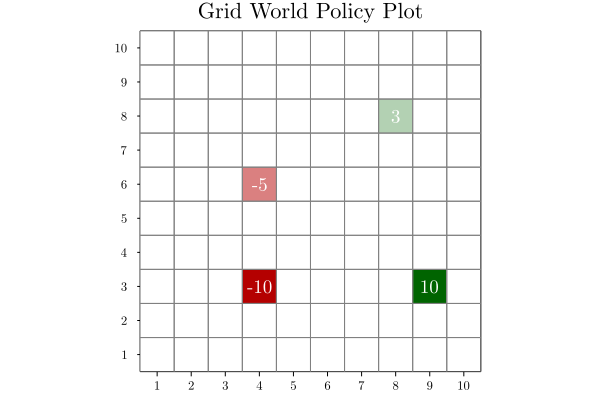

In [321]:
my_render(mdp; show_rewards=true)

In [319]:
using DiscreteValueIteration

In [431]:
solver = ValueIterationSolver(max_iterations=30);

In [432]:
policy = solve(solver, mdp)

ValueIterationPolicy:
 State(1, 1) -> DOWN
 State(2, 1) -> LEFT
 State(3, 1) -> LEFT
 State(4, 1) -> RIGHT
 State(5, 1) -> RIGHT
 State(6, 1) -> RIGHT
 State(7, 1) -> RIGHT
 State(8, 1) -> UP
 State(9, 1) -> UP
 State(10, 1) -> UP
 State(1, 2) -> DOWN
 State(2, 2) -> LEFT
 State(3, 2) -> DOWN
 State(4, 2) -> RIGHT
 State(5, 2) -> RIGHT
 State(6, 2) -> RIGHT
 State(7, 2) -> RIGHT
 State(8, 2) -> RIGHT
 State(9, 2) -> UP
 …

In [433]:
function plot_transition_probability(distr)
	if distr isa Deterministic
		vals = [distr.val]
		probs = [1]
	else
		vals = distr.vals
		probs = distr.probs
	end
	xtick_states = [(v.x,v.y) for v in vals]
	@info xtick_states
	@info probs
	cmap_probs = ColorScheme([colorant"#B3BCDB", colorant"#4063D8"])
	bar(probs,
		xformatter = x->1 <= x <= length(xtick_states) ? xtick_states[Int(x)] : "",
		label=false,
		aspect_ratio=5,
		group=xtick_states,
		color=map(v->get(cmap_probs, v), probs))
	title!("Transition Probability\nDistribution")
	xlabel!("next state 𝑠′")
	ylabel!("probability")
	ylims!(0, 1.1)
	xlims!(0, 6)
	yticks!(0:0.1:1)
end

plot_transition_probability (generic function with 1 method)

In [434]:
state_x = 8
state_y = 3
sᵣ = State(state_x, state_y)
aᵣ = action(policy, sᵣ)

RIGHT::Action = 3

In [435]:
distr = transition(mdp, sᵣ, aᵣ)

                         SparseCat distribution           
               ┌                                        ┐ 
   State(8, 3) ┤ 0.0                                      
   State(8, 4) ┤■■■■■ 0.10000000000000002                 
   State(8, 2) ┤■■■■■ 0.10000000000000002                 
   State(7, 3) ┤■■■■■ 0.10000000000000002                 
   State(9, 3) ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0.7   
               └                                        ┘ 

┌ Info: [(8, 3), (8, 4), (8, 2), (7, 3), (9, 3)]
└ @ Main /home/carlchan/JuliaProjects/Decision-Making-Under-Uncertainty/notebooks/test.ipynb:10
┌ Info: [0.0, 0.10000000000000002, 0.10000000000000002, 0.10000000000000002, 0.7]
└ @ Main /home/carlchan/JuliaProjects/Decision-Making-Under-Uncertainty/notebooks/test.ipynb:11


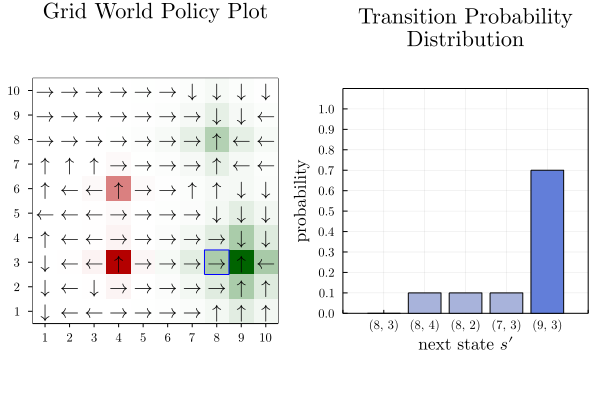

In [436]:
begin
	grid_plot = my_render(mdp, policy, 30; outline=false, outline_state=sᵣ)
	distr_plot = plot_transition_probability(distr)
	Plots.plot(grid_plot, distr_plot, layout=2)
end

In [437]:
value(policy, sᵣ)

3.3105749374196884

In [438]:
Q(π, s, a) = value(π, s, a) # Q-value (i.e., state-action value)

Q (generic function with 1 method)

In [439]:
U(π, s) = maximum(a->Q(π, s, a), actions(mdp)) # utility

U (generic function with 1 method)

In [440]:
U(policy, sᵣ) == value(policy, sᵣ)

true

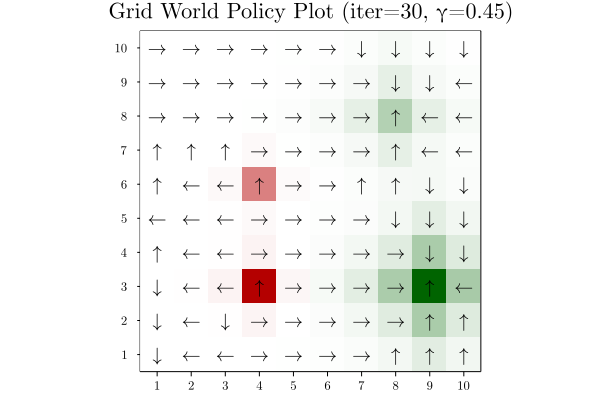

In [446]:
my_render(mdp, policy, 30, γ; outline=false)

In [489]:
γ_vi = 0.95
vi_iterations = 2

2

In [490]:
vi_mdp = QuickMDP(GridWorld,
    states       = 𝒮,
    actions      = 𝒜,
    transition   = T,
    reward       = R,
    discount     = γ_vi, # custom discount for visualization of Value Iteration policy
    initialstate = 𝒮,
    isterminal   = termination);

In [491]:
vi_solver = ValueIterationSolver(max_iterations=vi_iterations);

In [492]:
vi_policy = solve(vi_solver, vi_mdp);

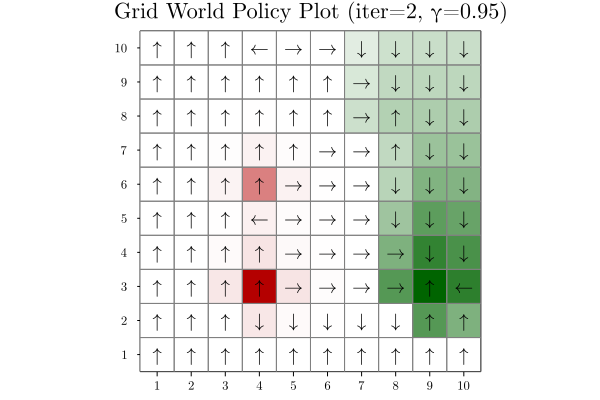

In [493]:
viz = my_render(vi_mdp, vi_policy, vi_iterations, γ_vi)

In [494]:
Plots.savefig(viz, "gridworld.svg")

In [495]:
using Reel

In [496]:
function create_value_iteration_gif()
	frames = Frames(MIME("image/png"), fps=2)
	push!(frames, render(vi_mdp, NothingPolicy(), 0, γ_vi; outline=true))
	last_frame = nothing
	for iter in 0:21
		local_solver = ValueIterationSolver(max_iterations=iter)
		local_policy = solve(local_solver, vi_mdp)
		one_based_policy!(local_policy)
		last_frame = render(vi_mdp, local_policy, iter, γ_vi; outline=false)
		push!(frames, last_frame)
	end
	[push!(frames, last_frame) for _ in 1:10] # duplicate last frame
	!isdir("gifs") && mkdir("gifs") # create "gifs" directory
	write("gifs/gridworld_vi.gif", frames)
	LocalResource("./gifs/gridworld_vi.gif")
end

create_value_iteration_gif (generic function with 1 method)

In [497]:
# md"Create value iteration GIF? $(@bind create_gif CheckBox())"
create_gif = false

false

In [498]:
using PlutoUI

In [499]:
create_gif ? create_value_iteration_gif() : PlutoUI.LocalResource("./gifs/gridworld_vi.gif")

Resource("data:image/gif;base64,R0lGODlhWAKQAfcCAAAAAABkAAD/AAJUAgMEAwYhBgkMCQwyDA8iDxIxEhMTExZUFhZwFhZyFhglGBg4GBhCGBheGBkcGRkuGRlzGRpzGh11HSApICBEICEhISI5IiNdIyNpIyQwJCR5JCV6JSZ7JicqJydPJyhCKCh8KCprKit+Kyw1LCx+LC0CAi5/Li+ALzBBMDFWMTM2MzODMzRNNDRrNDVcNTZDNjaENjd4NzghITmGOTuHOzw7Oz0HBz1sPT2JPT5EPj+KP0BQQEBaQEKMQkOMQ0VFRUZ6RkaPRkdpR0eNR0ePR0iPSElKSUmHSUtQS0tcS0uRS02STU6TTlFPT1GVUVKHUlKVUlNTU1OXU1SXVFVWVVWXVVWYVVZlVlh5WFiaWFlZWVlvWVpdWlubW1ybXF2HXV2SXV6dXmN1Y2OgY2OgY2WhZWZmZmcAAGeiZ2hBQWmIaWmjaWmkaWpyamqdamuka22mbW5vbnB1cHCScHCocHGocXOec3SHdHWrdXasdnesd3h4eHmueXuve3x8fHyvfH6Tfn9/f3+xf4CcgIF7e4GygYKBgYKzgoS0hIaHhoe2h4i2iImuiYqfioqmioq4iouLi4y5jI66jpBUVJC7kJC7kJO8k5SUk5UAAJW+lZiZmJivmJjAmJqamprBmpzCnJ2lnZ3EnZ6dnZ/En5/Fn6DFoKFycqHFoaK8oqPHo6SlpKXCpaXIpaampqfEp6fIp6fKp6qqqqrFqqrLqqrLqqzMrK7Nrq7Orq8CArCvr7DIsLDOsLHPsbPQs7PRs7QAALW1tbXLtbXStbfTt7m6ubnUubvWu7zQvL3Xvb/Yv8C/v8HZwcHawcLIwsTExMTbxMfdx8jcyMndycrJycrfyszgzM7PztDi0NF7e9Lj0tPT09Tl1Nfn19jY2NqAgNro2t3d3d3r3d/f3+Hs4ePj4uTu5Ofv5+nx6erq6u707u/v7/L18vTg4PT49Pbg4Pbk4/fj4/fm5vfu7vn7+frx8fz4+P35+f3+/f78/P79/f/+/v///yH/C05FVFNDQVBFMi4wAwEAAAAh+QQFMgACACwAAAAAWAKQAYcAAAAAZAAA/wACVAIDBAMGIQYJDAkMMgwPIg8SMRITExMWVBYWcBYWchYYJRgYOBgYQhgYXhgZHBkZLhkZcxkacxoddR0gKSAgRCAhISEiOSIjXSMjaSMkMCQkeSQleiUmeyYnKicnTycoQigofCgqayorfissNSwsfiwtAgIufy4vgC8wQTAxVjEzNjMzgzM0TTQ0azQ1XDU2QzY2hDY3eDc4ISE5hjk7hzs8Ozs9Bwc9bD09iT0+RD4/ij9AUEBAWkBCjEJDjENFRUVGekZGj0ZHaUdHjUdHj0dIj0hJSklJh0lLUEtLXEtLkUtNkk1Ok05RT09RlVFSh1JSlVJTU1NTl1NUl1RVVlVVl1VVmFVWZVZYeVhYmlhZWVlZb1laXVpbm1tcm1xdh11dkl1enV5jdWNjoGNloWVmZmZnAABnomdoQUFpiGlpo2lppGlqcmpqnWprpGttpm1ub25wdXBwknBwqHBxqHFznnN0h3R1q3V2rHZ3rHd4eHh5rnl7r3t8fHx8r3x+k35/f39/sX+AnICBe3uBsoGCgYGCs4KEtISGh4aHtoeItoiJromKn4qKpoqKuIqLi4uMuYyOuo6QVFSQu5CTvJOUlJOVAACVvpWYmZiYr5iYwJiampqawZqcwpydpZ2dxJ2enZ2fxJ+fxZ+gxaChcnKhxaGivKKjx6OkpaSlwqWlyKWmpqanxKenyKenyqeqqqqqxaqqy6qszKyuza6uzq6vAgKwr6+wyLCwzrCxz7Gz0LOz0bO0AAC1tbW1y7W10rW307e5urm51Lm71ru80Ly9172/2L/Av7/B2cHB2sHCyMLExMTE28TH3cfI3MjJ3cnKycnK38rM4MzOz87Q4tDRe3vS49LT09PU5dTX59fY2NjagIDa6Nrd3d3d693f39/h7OHj4+Lk7uTn7+fp8enq6uru9O7v7+/y9fL04OD0+PT24OD25OP34+P35ub37u75+/n68fH8+Pj9+fn9/v3+/Pz+/f3//v7///////////////8I/wD5CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJkyhTqlx50Ns6ljBjKvSWTqbNmzgxstOV6RO1gdT2XaRXbls+nPrSuUy4jqZQkevClcspkN24cCKv0dFHtStKd2Bqeh1L9ua6NBLS6Co2yUs4XTkY0qNDCmG6HgYAiD2YxoUCBRmG0OM3KcdfCT28CeQU4u+QvQ+9SAAQDKGfDAAmMR3iAgCAEENCuxjC6unCSSEA1Bk4Ls2yj6yGKABAIEfoISHSKBbIqnOUkOWUDBZYLM1Um+EYJcoEGWa5SYkmNT+4LlOdROFM8ys2i53AdJ+wfv8f4q6s+fMnvQVOx1XguigS4i4sBsCAwkl6Fd7D/KxgFQCZFESPC7pU9AxlCaWTGUOp7caPPqwQgMVwC9FjwGoCBQLAECEts6Fp6WBhwCwEhfDbQ8VANER/A3Wm2UDr/JQSKzmMww81JwQVky4uYHXNCa8lRE0Gs+gTjguvEOSHZwrklUZ7i2GI3pRUbpROBiGwox0/6Sggn0Lu0MHJlgR9kp9CSzJS0CwAYGFQGhZtgyBC9Cy4UGfHDZQGAIk4JEEdT4UDRpAfUQMAEwWxY4ABNgqUw4kOQcpQMDloF0wajQr0zIsnhWPANgLtM4sEL7FUjgEybqfAdAKVo0AgTz3/8+lAfuSQQQZKBLOlOxKIV+WvwEb0H4kHJfKlQmQWZCarBBnqQkG61FfeQOWoWZGcldFpp0J4FsQKABk4pIAfUI5kKKIF5ZDZU48+tM6zDvVA7ED7bMkJpybVEYJp9hAQIEt+SABlPgowkiwdALD4oAJpPOWHgwgRQkewFFec0DYEGHDUQdv0kGxEyy60D2a+8kOHEgDoYtokEEuEbUJ14otQtwSxKcHHBUkwsUnnGjQEAIQM1K5DgbhQbkLjEFBqQu6EIDNJoGmHK0whwBtqCMeWCEDJJyhAa8sGPaPA0RaXDSwjGyakz876TEJIGu48E10+60zih5TfZRIII9eE/7xQHdvSU8e3XhBEh2ns2E3Iw08Vkwgdy6Rjd6MvD6SPLoEkwoo72yZE80CEAPCke4z4EUggmQr0p1DbMFLHmPTOAgYddKTIzyuvzMJKtsuwMktdQh5akD6TpTp0qLPQkUgdtvPjDeAZcMIJ8AlxckK5wTweJKUAVCE9ofzokkYgrgkUziR1aEZKIM27e6h2LkjwUDl0JElQOHVkC1E+BHhMkGEIwUye+KGu4zyMH+tIR7LcQYBUme2BVfKC6HBGL10wIWWzMFN3XtEYggQjA6+B0M+YRZAD5QAfxAnGOhZlj+8YTCDjCEG20uECVgiEGvhhRCDSQQAmsG5OXHIBIf9a6A2EPc0gn+OHq0Iglm2E4BlCCccJdDWQ1fEjHKQwQBUGQg8s5ECB+wADJ/hxKQIMIUjLyACSFNIzgkyCAEETGqTcwYRAcIUeszuKN4rhghAUoxjg4wsYCkINDf1rGdFKwx+9IZR9pGEI69jHlWaxj3KwIjCTCMcQCDCth4QDAIUjiAvs4xCUAeAT1JqMpByiICUU5GcUEuXWtCYjP0wiEKRgRA8c2KJ/QfCX6PkZoBwSrdVswzgCqYPXbjgiguyJhPSazHHqUB6UUTETjOQHPU6wsxs28CkKYGI+/ECsyg3IlQM50BEL4iLpTSINGfCDdxCYAWvxYx+6MICDrCj/EBdsMUMGKNUn5aOPDEgqDdC8EQBO8AnpJaIHLghGuY7XF34pgFNKcAEFheYHg6wDQDDqHD84QYBMZUIC0wJDBmzICj/UKxF+iKlMZyrT/lxDdBMFQCf/dikFTCsNIdBFqUpH06L64TXeaFNB

In [500]:
function create_discount_gif()
	frames_γ = Frames(MIME("image/png"), fps=2)
	last_frame_γ = nothing
	for γ_iter in 0:0.05:1
		local_solver = ValueIterationSolver(max_iterations=30)

		# local MDP to play around with γ
		vi_γ_mdp = QuickMDP(GridWorld,
			states       = 𝒮,
			actions      = 𝒜,
			transition   = T,
			reward       = R,
			discount     = γ_iter,
			initialstate = 𝒮,
			isterminal   = termination);

		local_π = solve(local_solver, vi_γ_mdp)
		one_based_policy!(local_π)
		last_frame_γ = render(vi_γ_mdp, local_π, 30, γ_iter; outline=false)
		push!(frames_γ, last_frame_γ)
	end
	[push!(frames_γ, last_frame_γ) for _ in 1:10] # duplicate last frame
	!isdir("gifs") && mkdir("gifs") # create "gifs" directory
	write("gifs/gridworld_vi_γ.gif", frames_γ)
	LocalResource("./gifs/gridworld_vi_γ.gif")
end

create_discount_gif (generic function with 1 method)

In [501]:
create_gif ? create_discount_gif() : LocalResource("./gifs/gridworld_vi_γ.gif")

Resource("data:image/gif;base64,R0lGODlhWAKQAfcJAAAAAAADAAASAAAnAAAyAAA9AABPAABcAABkAAD/AAEYAQEdAQFkAQJmAgQZBAQlBARlBARnBAUFBQUzBQVGBQVnBQZTBgdoBwhoCAliCQlpCQlqCQppCgs8CwtrCwwMDAxMDA1XDQ1rDQ4sDg5sDg9jDw9tDxEdERFpERFuERNvExQUFBVxFRZrFhZwFhhyGBlzGRlzGRoaGhwVFRxBHB11HR8eHiIiIiMmIyNdIyRQJCYyJil8KSo+KipvKisrKywAAC1/LS8xLy9jLy+ALzAvLzB+MDExMTIzMjQ0NDSDNDYHBzY2NjaFNjeFNzghITg6ODo/OjqHOjuHOzx4PDyFPD2JPT4+Pj4+PkBAQEFYQUJNQkKMQkNDQkRGREeOR0ePR0hISEhJSElJSUxNTEySTE5UTlGFUVI2NlNTU1OWU1RwVFVZVVcPD1hYWFhlWFxcW1ybXF4AAGBiYGGeYWJwYmKFYmOfY2ShZGZmZmhtaGmjaWqlamula2xISG1vbW+nb3FxcXR2dHWZdXWrdXh5eHmteXt+e3yvfH9+foCygIGygYGygYOEg4e2h4iIiIiNiIigiImriYu4i42OjZC7kJKTkpN7e5O9k5S8lJS+lJZYWJa+lpe/l5ivmJmZmZvCm5ydnJ0AAJ/En6KjoqKuoqTHpKXIpaampqnLqaqpqa3Nra+wr6+2r7DOsLEAALHPsbMAALPRs7QAALTRtLXStba2trbStrhsbLjFuLjRuLnUubu7u77Wvr/Yv8HBwcPaw8TGxMjdyMrKycvfy8zPzM14eM/hz9HS0dHj0dLj0tXj1dbV1dbm1td+ftqAgNro2tzc3Nzq3N7r3t/r3+Dp4ODs4OHh4ePu4+Tu5OXv5efo5+fw5+fw5+nx6eny6ezz7O3t7e307e/17/Hx8fH38fL38vT49PX59fb59vf69/ju7vj19fj5+Pj6+Pn8+fvw8Pvy8vv8+/z19fz39/z4+Pz9/P34+P36+v3+/f78/P78/P79/f7+/v7//v///yH/C05FVFNDQVBFMi4wAwEAAAAh+QQFMgAJACwAAAAAWAKQAYcAAAAAAwAAEgAAJwAAMgAAPQAATwAAXAAAZAAA/wABGAEBHQEBZAECZgIEGQQEJQQEZQQEZwQFBQUFMwUFRgUFZwUGUwYHaAcIaAgJYgkJaQkJagkKaQoLPAsLawsMDAwMTAwNVw0Naw0OLA4ObA4PYw8PbQ8RHRERaRERbhETbxMUFBQVcRUWaxYWcBYYchgZcxkaGhocFRUcQRwddR0fHh4iIiIjJiMjXSMkUCQmMiYpfCkqPioqbyorKyssAAAtfy0vMS8vYy8vgC8wLy8wfjAxMTEyMzI0NDQ0gzQ2Bwc2NjY2hTY3hTc4ISE4Ojg6Pzo6hzo7hzs8eDw8hTw9iT0+Pj5AQEBBWEFCTUJCjEJDQ0JERkRHjkdHj0dISEhISUhJSUlMTUxMkkxOVE5RhVFSNjZTU1NTllNUcFRVWVVXDw9YWFhYZVhcXFtcm1xeAABgYmBhnmFicGJihWJjn2NkoWRmZmZobWhpo2lqpWprpWtsSEhtb21vp29xcXF0dnR1mXV1q3V4eXh5rXl7fnt8r3x/fn6AsoCBsoGDhIOHtoeIiIiIjYiIoIiJq4mLuIuNjo2Qu5CSk5KTe3uTvZOUvJSUvpSWWFiWvpaXv5eYr5iZmZmbwpucnZydAACfxJ+io6KirqKkx6SlyKWmpqapy6mqqamtza2vsK+vtq+wzrCxAACxz7GzAACz0bO0AAC00bS10rW2tra20ra4bGy4xbi40bi51Lm7u7u+1r6/2L/BwcHD2sPExsTI3cjKysnL38vMz8zNeHjP4c/R0tHR49HS49LV49XW1dXW5tbXfn7agIDa6Nrc3Nzc6tze697f69/g6eDg7ODh4eHj7uPk7uTl7+Xn6Ofn8Ofp8enp8uns8+zt7e3t9O3v9e/x8fHx9/Hy9/L0+PT1+fX2+fb3+vf47u749fX4+fj4+vj5/Pn78PD78vL7/Pv89fX89/f8+Pj8/fz9+Pj9+vr9/v3+/Pz+/f3+/v7+//7///////////////////////8I/wD1CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJkyhTqlx50Fk3ljBjKnSJT6bNmzgvgks1yROwgb4wpsNWzB3Oe9iSgUvYzRk2kuCcUcspEBw1ZyKL9blHtStKdG6eeh1L9mY3PCvwpMoViY2zVFYYpvvjCWG3Kx8AdKt58I6RFStqbDEayQrgGFec1eTkA/CVlxHZrAAwCyEgGwAiJQTHhQgAADe4bOFihEspvgsZ+QAAaCC1OLw+luIyWQKU0Vt83Ek2sNQRAGJCUguTbmCuO9hQwwSmCNCkqQWpRToUSaxMbJEUMYKucJynQ4qEFf/E9qVc2fPoTya7ccW6PnBnVsRdOAvAB+UFGenFT9BdDQBBEXQGAJMUVA4SqVTEC2UJYZMZQzcAgJVA+JQiwRlGMeTOB38MNAgAXISUCwBboNaNGh+cQpAPwT2UC0RcBCjQEgAwQhA4P6GETyGhgOPOJBJwQlAqS/BWjBEvxpTLEcXokwwSs/A3kDNERImNGDYSxElr6XXpJUfY1HADOgZhIx9D6PTBiZQCebKfQoDUqNwpAKhh0B0WJcMgQu48uBASAHAn0B0AKMJmQStwqY8zcST5ETDAFQTOBx9MqI8VLTp0xqEFzfJEp3EI6kuWJ52ChIxPSJAjNh/ImMsK7qX/1M0KlQkEzAeCEoQPFIcMNGmtApUTg6VfFmssRAOqeJAi813k5l4KQXpEQanYh04+rpE6kZ7AGtSnZn8GWlAoANjgUKInQZrpQFbUyO66C3WzxENXKKsQJ9qW9KEbA7EBQF36DLICavesYChLjHxQ3EA1KFrQiMWgdkazAh3yB7bHZqzxQXp+kKFByVBc0bOc4vMfsX2IAUAqqEXCW0XcJvQtQ4DmSmcMnA6ErknqGrQFAL0KhOlDg0zbEDUBQJYQOj7kSxI1h7yszxUACkSE0QMRMS9LT9xQkBU+IPSHXgTFudRAvKzA1cZsb6xfiAjd04dA90x3Bzq8aHdPN5EM/9IhQdhMAp4wJC80diR8ufMHuW6g1gdq40QCyCGDSJ2LIn3kwvcg1NQU80D3pDKIIqGk46dCNRd0CABxDNSNIoMUwjmiXCbDCCCcrK0PPqe40UfmApVSyimh1MpLKMTrblDPBN0TAwDA8DX0QLz3ocgfufCVzB8B1MAJJwAnxFinmMemzyxQAHDG9+YLlModhdxhvjO3R3KPJ4V0SxE2EmxBoQRWUM4WPvCQbgAifAKhBiBSobxzhY0gYpDAxwjyBQCYZyD6kZE+0KGqtnnwWP66Q870cY9TqCwVp+AEAE4BjlI0hiCzsAEv8HGPUHDhTQrxBQA+JZBZzAIcElCYQP+woQjX+CBB+sDGEkJhq0jUqBD8a9HnkriEQxQnGX04XUJS55oV+ABaxfDB/HzQrZ05wxMfOMNA3DGxp+DDDUKaBR5AZD5e2MAIpYhWpAjixKAJLVPlEMMhjJION+DBc7lYwg1ywciFxKF1BAFGIQgkkFxU6w6MfBk+7sCFl2DDBqfIBzVCUQMuRMIZXJAAmSqCjS1sATLgAMAXClLBCzLEDZ9ZU1X+I7KG9ImHAxmQ0giCBAkox4lRIggRCvTBZnapgn9rSLVak4w7QOcPKxgIMCRgL33EAYcJwUcMAnBN84RhZQLhRDKw5Q4fRFMf25SRF7FhD0Ao63PuOMK6FgT/LtTV6HuRuEMNBnE2cNRAW6n4gNR2JhAkqFEghfgAZJwBACjURB41IANqkLMQSBHhe5xg1hKQ+K6B3AFr+ijHCkj1BZQqxAoOqwolBdINd2mJnAOZRAyupQ832ICJpRgEPvABu0EY9ahINaoG